In [1]:
# from https://github.com/gilbutITbook/080228.git (모두의 딥러닝)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
epoch:0  d_loss:0.7053  g_loss:0.6912
epoch:1  d_loss:0.4624  g_loss:0.3282
epoch:2  d_loss:0.5685  g_loss:0.1024
epoch:3  d_loss:0.6585  g_loss:0.0836
epoch:4  d_loss:0.5767  g_loss:0.1650
epoch:5  d_loss:0.5088  g_loss:0.4210
epoch:6  d_loss:0.4876  g_loss:0.6973
epoch:7  d_loss:0.5091  g_loss:0.8702
epoch:8  d_loss:0.4966  g_loss:0.8973
epoch:9  d_loss:0.4861  g_lo

epoch:189  d_loss:0.5098  g_loss:1.0539
epoch:190  d_loss:0.3928  g_loss:1.4539
epoch:191  d_loss:0.6349  g_loss:1.1273
epoch:192  d_loss:0.5740  g_loss:1.2414
epoch:193  d_loss:0.6313  g_loss:1.1240
epoch:194  d_loss:0.5867  g_loss:0.9635
epoch:195  d_loss:0.6164  g_loss:1.0993
epoch:196  d_loss:0.6779  g_loss:1.0231
epoch:197  d_loss:0.4889  g_loss:1.0840
epoch:198  d_loss:0.5898  g_loss:1.1969
epoch:199  d_loss:0.6405  g_loss:1.1768
epoch:200  d_loss:0.5192  g_loss:1.2602
epoch:201  d_loss:0.4717  g_loss:1.1546
epoch:202  d_loss:0.6609  g_loss:1.1129
epoch:203  d_loss:0.5036  g_loss:1.0502
epoch:204  d_loss:0.5272  g_loss:1.3910
epoch:205  d_loss:0.5543  g_loss:1.3656
epoch:206  d_loss:0.5068  g_loss:1.4507
epoch:207  d_loss:0.5471  g_loss:1.3168
epoch:208  d_loss:0.5633  g_loss:1.4043
epoch:209  d_loss:0.4209  g_loss:1.3457
epoch:210  d_loss:0.4972  g_loss:1.3637
epoch:211  d_loss:0.4388  g_loss:1.6021
epoch:212  d_loss:0.3838  g_loss:1.8117
epoch:213  d_loss:0.4928  g_loss:2.1202


epoch:394  d_loss:0.3516  g_loss:1.9713
epoch:395  d_loss:0.3132  g_loss:2.0266
epoch:396  d_loss:0.3592  g_loss:2.2904
epoch:397  d_loss:0.4274  g_loss:1.9908
epoch:398  d_loss:0.5041  g_loss:1.6347
epoch:399  d_loss:0.4140  g_loss:2.0177
epoch:400  d_loss:0.4453  g_loss:1.7072
epoch:401  d_loss:0.3553  g_loss:2.3010
epoch:402  d_loss:0.4155  g_loss:1.8675
epoch:403  d_loss:0.4261  g_loss:1.8925
epoch:404  d_loss:0.4814  g_loss:1.6779
epoch:405  d_loss:0.4339  g_loss:1.9182
epoch:406  d_loss:0.3634  g_loss:1.7623
epoch:407  d_loss:0.3086  g_loss:1.8845
epoch:408  d_loss:0.3988  g_loss:2.1276
epoch:409  d_loss:0.4644  g_loss:2.0199
epoch:410  d_loss:0.4222  g_loss:1.8244
epoch:411  d_loss:0.4503  g_loss:1.6082
epoch:412  d_loss:0.4297  g_loss:1.3050
epoch:413  d_loss:0.4907  g_loss:1.3111
epoch:414  d_loss:0.4590  g_loss:1.9938
epoch:415  d_loss:0.3685  g_loss:1.9188
epoch:416  d_loss:0.5274  g_loss:1.7651
epoch:417  d_loss:0.3413  g_loss:1.7325
epoch:418  d_loss:0.5780  g_loss:1.5203


epoch:599  d_loss:0.3328  g_loss:3.6969
epoch:600  d_loss:0.2997  g_loss:2.8351
epoch:601  d_loss:0.2112  g_loss:2.0426
epoch:602  d_loss:0.4897  g_loss:1.2233
epoch:603  d_loss:0.5967  g_loss:1.7017
epoch:604  d_loss:0.5643  g_loss:1.8076
epoch:605  d_loss:0.5788  g_loss:1.7416
epoch:606  d_loss:0.9218  g_loss:1.3700
epoch:607  d_loss:0.4790  g_loss:1.7079
epoch:608  d_loss:0.3621  g_loss:2.1489
epoch:609  d_loss:0.5479  g_loss:2.4385
epoch:610  d_loss:0.5746  g_loss:2.1641
epoch:611  d_loss:0.5066  g_loss:2.3157
epoch:612  d_loss:0.4980  g_loss:1.4221
epoch:613  d_loss:0.7172  g_loss:1.5012
epoch:614  d_loss:0.5108  g_loss:1.3523
epoch:615  d_loss:0.4371  g_loss:2.0396
epoch:616  d_loss:0.4019  g_loss:2.1217
epoch:617  d_loss:0.6094  g_loss:1.7241
epoch:618  d_loss:0.6278  g_loss:1.4777
epoch:619  d_loss:0.3847  g_loss:1.0976
epoch:620  d_loss:0.2724  g_loss:1.5039
epoch:621  d_loss:0.3245  g_loss:1.6428
epoch:622  d_loss:0.3182  g_loss:1.5916
epoch:623  d_loss:0.4176  g_loss:1.3843


epoch:804  d_loss:0.2536  g_loss:2.1231
epoch:805  d_loss:0.2192  g_loss:2.0969
epoch:806  d_loss:0.2877  g_loss:1.8460
epoch:807  d_loss:0.2566  g_loss:2.0075
epoch:808  d_loss:0.2682  g_loss:2.0098
epoch:809  d_loss:0.2197  g_loss:2.4457
epoch:810  d_loss:0.2571  g_loss:2.4082
epoch:811  d_loss:0.2563  g_loss:2.4291
epoch:812  d_loss:0.3771  g_loss:1.8182
epoch:813  d_loss:0.3854  g_loss:1.8719
epoch:814  d_loss:0.2550  g_loss:1.9655
epoch:815  d_loss:0.3597  g_loss:1.8344
epoch:816  d_loss:0.4471  g_loss:1.5640
epoch:817  d_loss:0.3965  g_loss:1.9845
epoch:818  d_loss:0.3892  g_loss:2.4145
epoch:819  d_loss:0.5216  g_loss:1.7257
epoch:820  d_loss:0.5115  g_loss:1.2695
epoch:821  d_loss:0.4212  g_loss:1.5269
epoch:822  d_loss:0.4802  g_loss:1.3887
epoch:823  d_loss:0.4959  g_loss:1.4909
epoch:824  d_loss:0.5262  g_loss:1.6588
epoch:825  d_loss:0.4525  g_loss:2.0249
epoch:826  d_loss:0.6781  g_loss:1.4042
epoch:827  d_loss:0.6741  g_loss:1.2490
epoch:828  d_loss:0.5755  g_loss:1.4247


epoch:1009  d_loss:0.3140  g_loss:2.4874
epoch:1010  d_loss:0.3643  g_loss:2.3587
epoch:1011  d_loss:0.2952  g_loss:2.9673
epoch:1012  d_loss:0.2897  g_loss:3.2379
epoch:1013  d_loss:0.2810  g_loss:2.9824
epoch:1014  d_loss:0.2321  g_loss:3.0153
epoch:1015  d_loss:0.2214  g_loss:3.2564
epoch:1016  d_loss:0.3152  g_loss:3.2917
epoch:1017  d_loss:0.3040  g_loss:3.3098
epoch:1018  d_loss:0.3364  g_loss:2.8989
epoch:1019  d_loss:0.2308  g_loss:2.3876
epoch:1020  d_loss:0.2306  g_loss:2.7000
epoch:1021  d_loss:0.2034  g_loss:2.9481
epoch:1022  d_loss:0.2214  g_loss:3.0152
epoch:1023  d_loss:0.1687  g_loss:3.4678
epoch:1024  d_loss:0.2199  g_loss:2.9158
epoch:1025  d_loss:0.3256  g_loss:2.6435
epoch:1026  d_loss:0.3129  g_loss:2.1064
epoch:1027  d_loss:0.3889  g_loss:1.9939
epoch:1028  d_loss:0.3681  g_loss:2.5158
epoch:1029  d_loss:0.2736  g_loss:3.3305
epoch:1030  d_loss:0.3752  g_loss:3.0431
epoch:1031  d_loss:0.2966  g_loss:3.4404
epoch:1032  d_loss:0.3398  g_loss:2.9814
epoch:1033  d_lo

epoch:1209  d_loss:0.4240  g_loss:1.6634
epoch:1210  d_loss:0.3985  g_loss:1.7727
epoch:1211  d_loss:0.4845  g_loss:2.3451
epoch:1212  d_loss:0.3667  g_loss:2.0205
epoch:1213  d_loss:0.4537  g_loss:1.7431
epoch:1214  d_loss:0.3754  g_loss:1.5788
epoch:1215  d_loss:0.4462  g_loss:1.7328
epoch:1216  d_loss:0.4012  g_loss:1.9613
epoch:1217  d_loss:0.4170  g_loss:1.9121
epoch:1218  d_loss:0.4172  g_loss:2.2781
epoch:1219  d_loss:0.5267  g_loss:1.5090
epoch:1220  d_loss:0.3813  g_loss:1.7957
epoch:1221  d_loss:0.4619  g_loss:1.8896
epoch:1222  d_loss:0.4731  g_loss:1.6929
epoch:1223  d_loss:0.3681  g_loss:1.9305
epoch:1224  d_loss:0.4557  g_loss:1.8310
epoch:1225  d_loss:0.5125  g_loss:1.6364
epoch:1226  d_loss:0.4849  g_loss:1.4595
epoch:1227  d_loss:0.4966  g_loss:1.5180
epoch:1228  d_loss:0.4807  g_loss:2.0117
epoch:1229  d_loss:0.3894  g_loss:2.0653
epoch:1230  d_loss:0.4014  g_loss:2.0106
epoch:1231  d_loss:0.4795  g_loss:1.6527
epoch:1232  d_loss:0.4185  g_loss:1.4644
epoch:1233  d_lo

epoch:1409  d_loss:0.5273  g_loss:1.3643
epoch:1410  d_loss:0.4972  g_loss:1.6631
epoch:1411  d_loss:0.4426  g_loss:1.9552
epoch:1412  d_loss:0.4912  g_loss:1.7785
epoch:1413  d_loss:0.4676  g_loss:1.9533
epoch:1414  d_loss:0.4824  g_loss:2.0232
epoch:1415  d_loss:0.3288  g_loss:1.8645
epoch:1416  d_loss:0.4468  g_loss:1.8209
epoch:1417  d_loss:0.3939  g_loss:2.5291
epoch:1418  d_loss:0.2843  g_loss:2.4743
epoch:1419  d_loss:0.5503  g_loss:2.1139
epoch:1420  d_loss:0.4343  g_loss:1.7339
epoch:1421  d_loss:0.4693  g_loss:1.6504
epoch:1422  d_loss:0.5810  g_loss:1.5057
epoch:1423  d_loss:0.4828  g_loss:1.7139
epoch:1424  d_loss:0.4735  g_loss:1.7316
epoch:1425  d_loss:0.5004  g_loss:1.5290
epoch:1426  d_loss:0.4212  g_loss:1.5543
epoch:1427  d_loss:0.4108  g_loss:1.1744
epoch:1428  d_loss:0.5510  g_loss:1.8391
epoch:1429  d_loss:0.5290  g_loss:1.5881
epoch:1430  d_loss:0.5557  g_loss:1.6153
epoch:1431  d_loss:0.5251  g_loss:1.4349
epoch:1432  d_loss:0.4544  g_loss:1.4685
epoch:1433  d_lo

epoch:1609  d_loss:0.5077  g_loss:1.7220
epoch:1610  d_loss:0.3480  g_loss:2.1051
epoch:1611  d_loss:0.4250  g_loss:2.0782
epoch:1612  d_loss:0.4122  g_loss:2.3252
epoch:1613  d_loss:0.3310  g_loss:2.6713
epoch:1614  d_loss:0.4828  g_loss:1.9705
epoch:1615  d_loss:0.4383  g_loss:1.7547
epoch:1616  d_loss:0.5346  g_loss:1.3606
epoch:1617  d_loss:0.4946  g_loss:1.4141
epoch:1618  d_loss:0.5034  g_loss:1.6006
epoch:1619  d_loss:0.4978  g_loss:1.8559
epoch:1620  d_loss:0.6780  g_loss:1.5586
epoch:1621  d_loss:0.4864  g_loss:2.0676
epoch:1622  d_loss:0.6661  g_loss:1.6906
epoch:1623  d_loss:0.6569  g_loss:1.3650
epoch:1624  d_loss:0.6369  g_loss:1.2967
epoch:1625  d_loss:0.6339  g_loss:1.3146
epoch:1626  d_loss:0.5515  g_loss:1.6539
epoch:1627  d_loss:0.6345  g_loss:1.5930
epoch:1628  d_loss:0.5778  g_loss:1.6915
epoch:1629  d_loss:0.5507  g_loss:1.7437
epoch:1630  d_loss:0.5938  g_loss:1.7232
epoch:1631  d_loss:0.5058  g_loss:1.4274
epoch:1632  d_loss:0.5291  g_loss:1.3841
epoch:1633  d_lo

epoch:1809  d_loss:0.3672  g_loss:2.2473
epoch:1810  d_loss:0.5767  g_loss:1.8720
epoch:1811  d_loss:0.6164  g_loss:1.6570
epoch:1812  d_loss:0.4989  g_loss:1.3583
epoch:1813  d_loss:0.4771  g_loss:1.7909
epoch:1814  d_loss:0.5284  g_loss:1.7291
epoch:1815  d_loss:0.5074  g_loss:1.4559
epoch:1816  d_loss:0.5036  g_loss:1.6290
epoch:1817  d_loss:0.4732  g_loss:1.3026
epoch:1818  d_loss:0.4897  g_loss:1.3209
epoch:1819  d_loss:0.6477  g_loss:1.2286
epoch:1820  d_loss:0.5368  g_loss:1.5118
epoch:1821  d_loss:0.4392  g_loss:1.2585
epoch:1822  d_loss:0.5648  g_loss:1.4172
epoch:1823  d_loss:0.6276  g_loss:1.7123
epoch:1824  d_loss:0.6062  g_loss:1.4095
epoch:1825  d_loss:0.5011  g_loss:1.7281
epoch:1826  d_loss:0.5197  g_loss:1.4797
epoch:1827  d_loss:0.7159  g_loss:1.5200
epoch:1828  d_loss:0.4435  g_loss:1.5895
epoch:1829  d_loss:0.5531  g_loss:1.4603
epoch:1830  d_loss:0.4314  g_loss:1.7604
epoch:1831  d_loss:0.4940  g_loss:1.6574
epoch:1832  d_loss:0.4293  g_loss:1.6302
epoch:1833  d_lo

epoch:2009  d_loss:0.6634  g_loss:1.6037
epoch:2010  d_loss:0.3825  g_loss:1.6070
epoch:2011  d_loss:0.4715  g_loss:1.5818
epoch:2012  d_loss:0.5049  g_loss:1.5459
epoch:2013  d_loss:0.5197  g_loss:1.6518
epoch:2014  d_loss:0.6124  g_loss:1.4059
epoch:2015  d_loss:0.5629  g_loss:1.4410
epoch:2016  d_loss:0.4465  g_loss:1.5327
epoch:2017  d_loss:0.5628  g_loss:1.5474
epoch:2018  d_loss:0.5220  g_loss:1.7040
epoch:2019  d_loss:0.5744  g_loss:1.7352
epoch:2020  d_loss:0.4140  g_loss:1.6555
epoch:2021  d_loss:0.5496  g_loss:1.4390
epoch:2022  d_loss:0.4236  g_loss:1.5099
epoch:2023  d_loss:0.4675  g_loss:2.0353
epoch:2024  d_loss:0.5241  g_loss:2.1261
epoch:2025  d_loss:0.4093  g_loss:1.8281
epoch:2026  d_loss:0.4883  g_loss:1.6646
epoch:2027  d_loss:0.4497  g_loss:1.7931
epoch:2028  d_loss:0.6049  g_loss:1.2359
epoch:2029  d_loss:0.5212  g_loss:1.6646
epoch:2030  d_loss:0.4495  g_loss:1.4623
epoch:2031  d_loss:0.6036  g_loss:1.6095
epoch:2032  d_loss:0.4338  g_loss:1.8492
epoch:2033  d_lo

epoch:2209  d_loss:0.8552  g_loss:1.1657
epoch:2210  d_loss:0.6831  g_loss:1.1927
epoch:2211  d_loss:0.6777  g_loss:1.3211
epoch:2212  d_loss:0.6333  g_loss:1.5138
epoch:2213  d_loss:0.5929  g_loss:1.5866
epoch:2214  d_loss:0.4749  g_loss:1.4602
epoch:2215  d_loss:0.6093  g_loss:1.5982
epoch:2216  d_loss:0.4443  g_loss:1.4250
epoch:2217  d_loss:0.5694  g_loss:1.0602
epoch:2218  d_loss:0.4385  g_loss:1.4266
epoch:2219  d_loss:0.3578  g_loss:1.9266
epoch:2220  d_loss:0.4495  g_loss:1.6415
epoch:2221  d_loss:0.5876  g_loss:1.4494
epoch:2222  d_loss:0.4108  g_loss:1.7505
epoch:2223  d_loss:0.4159  g_loss:1.5579
epoch:2224  d_loss:0.4158  g_loss:1.5725
epoch:2225  d_loss:0.4548  g_loss:1.6382
epoch:2226  d_loss:0.4062  g_loss:1.8695
epoch:2227  d_loss:0.4227  g_loss:1.8617
epoch:2228  d_loss:0.4330  g_loss:1.6770
epoch:2229  d_loss:0.3966  g_loss:1.6313
epoch:2230  d_loss:0.3951  g_loss:2.0410
epoch:2231  d_loss:0.4234  g_loss:1.3822
epoch:2232  d_loss:0.5309  g_loss:1.6186
epoch:2233  d_lo

epoch:2409  d_loss:0.4941  g_loss:1.4007
epoch:2410  d_loss:0.4352  g_loss:1.7826
epoch:2411  d_loss:0.6936  g_loss:1.3567
epoch:2412  d_loss:0.5655  g_loss:1.3794
epoch:2413  d_loss:0.4062  g_loss:1.4909
epoch:2414  d_loss:0.5767  g_loss:1.7820
epoch:2415  d_loss:0.4793  g_loss:2.0971
epoch:2416  d_loss:0.5831  g_loss:2.1219
epoch:2417  d_loss:0.6642  g_loss:1.7633
epoch:2418  d_loss:0.6026  g_loss:1.2314
epoch:2419  d_loss:0.6796  g_loss:1.4382
epoch:2420  d_loss:0.4700  g_loss:1.4371
epoch:2421  d_loss:0.6198  g_loss:1.3945
epoch:2422  d_loss:0.5124  g_loss:1.3961
epoch:2423  d_loss:0.3999  g_loss:1.7024
epoch:2424  d_loss:0.5174  g_loss:1.6989
epoch:2425  d_loss:0.4974  g_loss:1.4132
epoch:2426  d_loss:0.5165  g_loss:1.6996
epoch:2427  d_loss:0.5569  g_loss:1.4734
epoch:2428  d_loss:0.5205  g_loss:1.5087
epoch:2429  d_loss:0.5330  g_loss:1.5134
epoch:2430  d_loss:0.6190  g_loss:1.1179
epoch:2431  d_loss:0.5121  g_loss:1.1516
epoch:2432  d_loss:0.6220  g_loss:1.5669
epoch:2433  d_lo

epoch:2609  d_loss:0.4258  g_loss:1.9097
epoch:2610  d_loss:0.4316  g_loss:1.7561
epoch:2611  d_loss:0.4978  g_loss:1.9519
epoch:2612  d_loss:0.5286  g_loss:1.8660
epoch:2613  d_loss:0.3880  g_loss:1.6550
epoch:2614  d_loss:0.4082  g_loss:1.9867
epoch:2615  d_loss:0.4232  g_loss:1.8005
epoch:2616  d_loss:0.4537  g_loss:1.4227
epoch:2617  d_loss:0.4751  g_loss:1.9934
epoch:2618  d_loss:0.4459  g_loss:1.6614
epoch:2619  d_loss:0.6166  g_loss:1.6650
epoch:2620  d_loss:0.6862  g_loss:1.7234
epoch:2621  d_loss:0.7157  g_loss:1.6852
epoch:2622  d_loss:0.5806  g_loss:1.3314
epoch:2623  d_loss:0.6486  g_loss:1.8264
epoch:2624  d_loss:0.6332  g_loss:1.6392
epoch:2625  d_loss:0.6446  g_loss:1.4006
epoch:2626  d_loss:0.5946  g_loss:1.4375
epoch:2627  d_loss:0.5857  g_loss:1.4916
epoch:2628  d_loss:0.5664  g_loss:1.6908
epoch:2629  d_loss:0.6651  g_loss:1.4468
epoch:2630  d_loss:0.5735  g_loss:1.2227
epoch:2631  d_loss:0.4890  g_loss:1.4366
epoch:2632  d_loss:0.5409  g_loss:1.2956
epoch:2633  d_lo

epoch:2809  d_loss:0.4819  g_loss:1.5309
epoch:2810  d_loss:0.3681  g_loss:1.7388
epoch:2811  d_loss:0.3516  g_loss:1.8715
epoch:2812  d_loss:0.4654  g_loss:1.6230
epoch:2813  d_loss:0.3777  g_loss:1.6802
epoch:2814  d_loss:0.4942  g_loss:1.5319
epoch:2815  d_loss:0.5002  g_loss:1.6501
epoch:2816  d_loss:0.4161  g_loss:1.6877
epoch:2817  d_loss:0.4897  g_loss:1.6835
epoch:2818  d_loss:0.5392  g_loss:1.5981
epoch:2819  d_loss:0.3886  g_loss:2.2784
epoch:2820  d_loss:0.4562  g_loss:2.1378
epoch:2821  d_loss:0.5209  g_loss:1.9008
epoch:2822  d_loss:0.5001  g_loss:1.6354
epoch:2823  d_loss:0.5141  g_loss:1.4438
epoch:2824  d_loss:0.4935  g_loss:1.5543
epoch:2825  d_loss:0.5066  g_loss:1.9224
epoch:2826  d_loss:0.4839  g_loss:2.1985
epoch:2827  d_loss:0.4368  g_loss:1.9706
epoch:2828  d_loss:0.4763  g_loss:2.2367
epoch:2829  d_loss:0.5371  g_loss:2.2541
epoch:2830  d_loss:0.4725  g_loss:2.1047
epoch:2831  d_loss:0.5572  g_loss:2.0298
epoch:2832  d_loss:0.4103  g_loss:1.8838
epoch:2833  d_lo

epoch:3009  d_loss:0.3608  g_loss:1.8238
epoch:3010  d_loss:0.3312  g_loss:1.9607
epoch:3011  d_loss:0.3551  g_loss:2.2264
epoch:3012  d_loss:0.2878  g_loss:2.1084
epoch:3013  d_loss:0.4435  g_loss:1.7760
epoch:3014  d_loss:0.3670  g_loss:1.9034
epoch:3015  d_loss:0.3861  g_loss:2.0539
epoch:3016  d_loss:0.3943  g_loss:1.7940
epoch:3017  d_loss:0.4691  g_loss:1.8325
epoch:3018  d_loss:0.3525  g_loss:1.6186
epoch:3019  d_loss:0.4582  g_loss:1.5528
epoch:3020  d_loss:0.6356  g_loss:1.5646
epoch:3021  d_loss:0.5525  g_loss:1.3205
epoch:3022  d_loss:0.5419  g_loss:1.5850
epoch:3023  d_loss:0.4358  g_loss:1.7486
epoch:3024  d_loss:0.5400  g_loss:1.7388
epoch:3025  d_loss:0.5923  g_loss:1.7022
epoch:3026  d_loss:0.4686  g_loss:1.5575
epoch:3027  d_loss:0.5456  g_loss:1.4142
epoch:3028  d_loss:0.5904  g_loss:1.2643
epoch:3029  d_loss:0.5934  g_loss:1.5052
epoch:3030  d_loss:0.5725  g_loss:1.5733
epoch:3031  d_loss:0.6588  g_loss:1.6529
epoch:3032  d_loss:0.6039  g_loss:1.5072
epoch:3033  d_lo

epoch:3209  d_loss:0.4824  g_loss:1.5089
epoch:3210  d_loss:0.5496  g_loss:1.5764
epoch:3211  d_loss:0.5361  g_loss:1.5502
epoch:3212  d_loss:0.4694  g_loss:1.8200
epoch:3213  d_loss:0.5258  g_loss:1.8019
epoch:3214  d_loss:0.5172  g_loss:1.2595
epoch:3215  d_loss:0.6800  g_loss:1.0786
epoch:3216  d_loss:0.4605  g_loss:1.2660
epoch:3217  d_loss:0.5841  g_loss:1.3046
epoch:3218  d_loss:0.3952  g_loss:1.4327
epoch:3219  d_loss:0.4829  g_loss:1.4072
epoch:3220  d_loss:0.4981  g_loss:1.8070
epoch:3221  d_loss:0.5361  g_loss:2.0266
epoch:3222  d_loss:0.4791  g_loss:1.5484
epoch:3223  d_loss:0.5366  g_loss:1.4369
epoch:3224  d_loss:0.3906  g_loss:1.3155
epoch:3225  d_loss:0.4793  g_loss:1.5661
epoch:3226  d_loss:0.5194  g_loss:1.3789
epoch:3227  d_loss:0.4508  g_loss:1.4798
epoch:3228  d_loss:0.4554  g_loss:1.5246
epoch:3229  d_loss:0.5583  g_loss:1.5363
epoch:3230  d_loss:0.4410  g_loss:1.4389
epoch:3231  d_loss:0.4192  g_loss:1.4560
epoch:3232  d_loss:0.5326  g_loss:1.7617
epoch:3233  d_lo

epoch:3409  d_loss:0.3982  g_loss:1.4011
epoch:3410  d_loss:0.3525  g_loss:1.6944
epoch:3411  d_loss:0.4816  g_loss:1.7577
epoch:3412  d_loss:0.4010  g_loss:1.6670
epoch:3413  d_loss:0.4443  g_loss:1.7490
epoch:3414  d_loss:0.3752  g_loss:1.8166
epoch:3415  d_loss:0.6435  g_loss:1.6564
epoch:3416  d_loss:0.6210  g_loss:1.4104
epoch:3417  d_loss:0.3796  g_loss:1.5950
epoch:3418  d_loss:0.4696  g_loss:1.7653
epoch:3419  d_loss:0.5052  g_loss:1.9083
epoch:3420  d_loss:0.4240  g_loss:1.8418
epoch:3421  d_loss:0.4414  g_loss:1.7290
epoch:3422  d_loss:0.4721  g_loss:1.9786
epoch:3423  d_loss:0.5318  g_loss:1.9132
epoch:3424  d_loss:0.5058  g_loss:1.7792
epoch:3425  d_loss:0.4261  g_loss:1.7466
epoch:3426  d_loss:0.4641  g_loss:1.5552
epoch:3427  d_loss:0.4178  g_loss:1.5041
epoch:3428  d_loss:0.4243  g_loss:1.8286
epoch:3429  d_loss:0.4690  g_loss:2.0089
epoch:3430  d_loss:0.3693  g_loss:1.6960
epoch:3431  d_loss:0.3459  g_loss:1.7199
epoch:3432  d_loss:0.5793  g_loss:1.5612
epoch:3433  d_lo

epoch:3609  d_loss:0.4612  g_loss:1.6567
epoch:3610  d_loss:0.4605  g_loss:1.9878
epoch:3611  d_loss:0.4373  g_loss:1.8080
epoch:3612  d_loss:0.5876  g_loss:1.3612
epoch:3613  d_loss:0.3589  g_loss:2.0223
epoch:3614  d_loss:0.4890  g_loss:1.6888
epoch:3615  d_loss:0.6050  g_loss:1.9857
epoch:3616  d_loss:0.4662  g_loss:1.9450
epoch:3617  d_loss:0.5343  g_loss:2.0843
epoch:3618  d_loss:0.4679  g_loss:2.0350
epoch:3619  d_loss:0.3455  g_loss:2.0040
epoch:3620  d_loss:0.4168  g_loss:1.7808
epoch:3621  d_loss:0.4654  g_loss:1.9641
epoch:3622  d_loss:0.5062  g_loss:1.9481
epoch:3623  d_loss:0.5021  g_loss:2.0925
epoch:3624  d_loss:0.4050  g_loss:2.0570
epoch:3625  d_loss:0.5264  g_loss:2.0891
epoch:3626  d_loss:0.4601  g_loss:1.8141
epoch:3627  d_loss:0.5011  g_loss:1.7603
epoch:3628  d_loss:0.4299  g_loss:2.1855
epoch:3629  d_loss:0.5925  g_loss:1.5352
epoch:3630  d_loss:0.4999  g_loss:1.6839
epoch:3631  d_loss:0.3019  g_loss:2.1621
epoch:3632  d_loss:0.5162  g_loss:1.8379
epoch:3633  d_lo

epoch:3809  d_loss:0.4412  g_loss:1.3486
epoch:3810  d_loss:0.4049  g_loss:1.8066
epoch:3811  d_loss:0.4591  g_loss:2.1333
epoch:3812  d_loss:0.4491  g_loss:1.9263
epoch:3813  d_loss:0.4832  g_loss:1.4622
epoch:3814  d_loss:0.4760  g_loss:1.2826
epoch:3815  d_loss:0.4885  g_loss:1.6297
epoch:3816  d_loss:0.4443  g_loss:1.7067
epoch:3817  d_loss:0.3724  g_loss:2.0162
epoch:3818  d_loss:0.5230  g_loss:1.9357
epoch:3819  d_loss:0.4200  g_loss:1.9250
epoch:3820  d_loss:0.5483  g_loss:1.3097
epoch:3821  d_loss:0.5047  g_loss:1.2682
epoch:3822  d_loss:0.3060  g_loss:1.8886
epoch:3823  d_loss:0.3745  g_loss:1.9189
epoch:3824  d_loss:0.4565  g_loss:1.3960
epoch:3825  d_loss:0.5745  g_loss:1.7403
epoch:3826  d_loss:0.6162  g_loss:1.3604
epoch:3827  d_loss:0.3761  g_loss:1.7774
epoch:3828  d_loss:0.4353  g_loss:1.5369
epoch:3829  d_loss:0.5350  g_loss:1.5020
epoch:3830  d_loss:0.4667  g_loss:1.4047
epoch:3831  d_loss:0.4904  g_loss:1.6513
epoch:3832  d_loss:0.4786  g_loss:1.3002
epoch:3833  d_lo

<ipython-input-2-54e8c3e11c4c>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(5, 5)


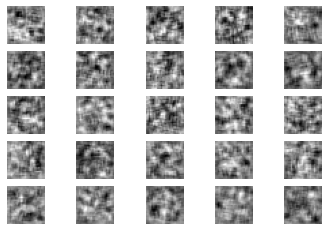

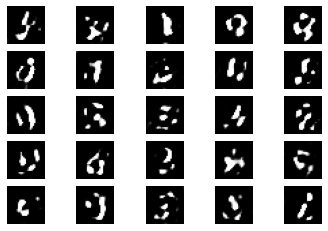

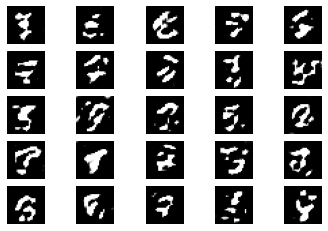

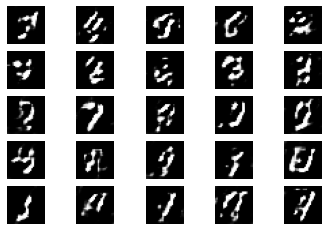

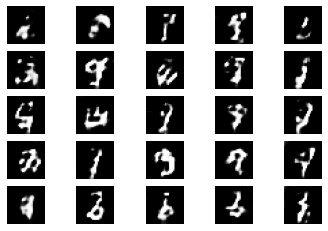

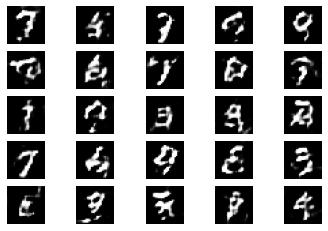

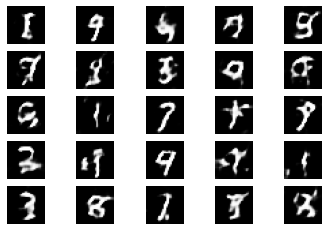

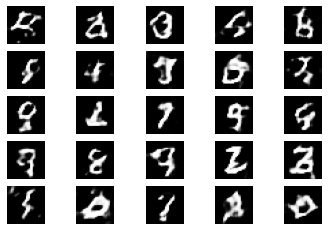

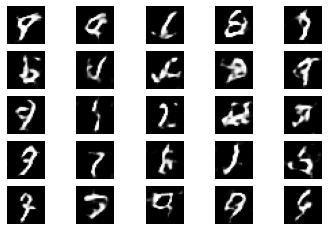

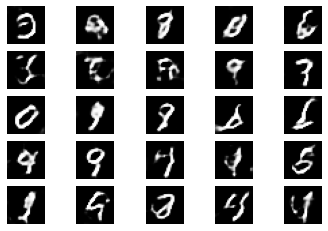

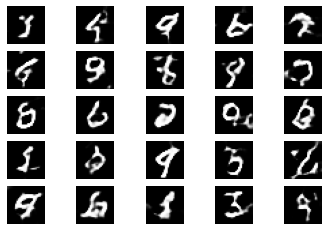

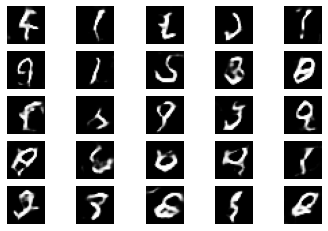

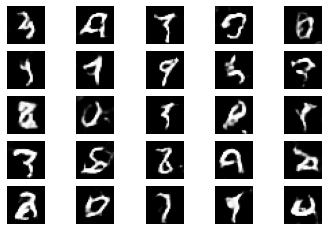

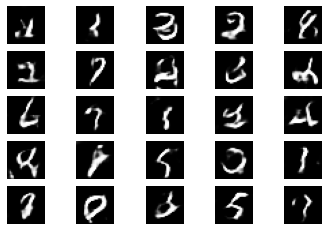

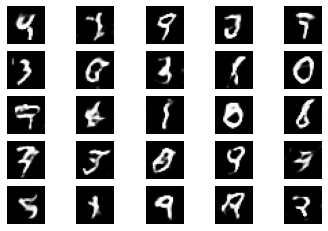

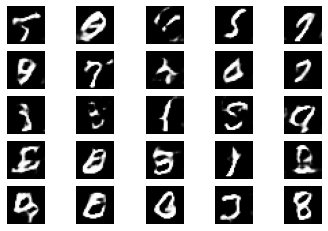

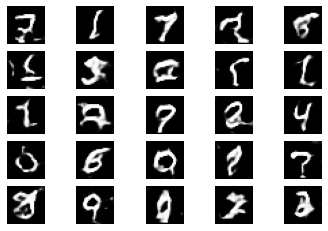

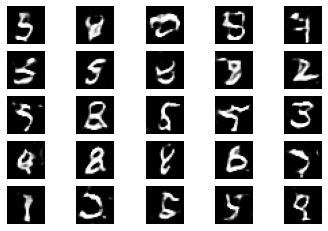

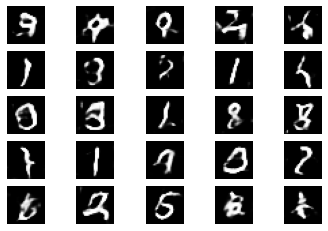

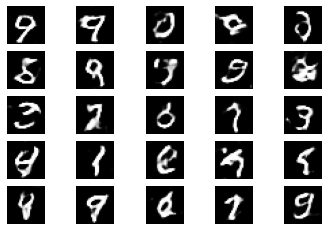

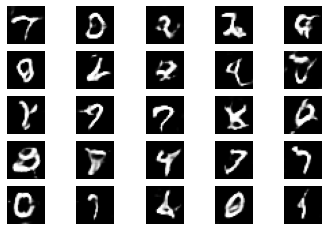

In [2]:
#-*- coding: utf-8 -*-

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

#이미지가 저장될 폴더가 없다면 만듭니다.
import os
if not os.path.exists("./model_gan_images"):
    os.makedirs("./model_gan_images")

np.random.seed(3)
tf.random.set_seed(3)

#생성자 모델을 만듭니다.
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size=5, padding='same'))
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))

#판별자 모델을 만듭니다.
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding="same"))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

#생성자와 판별자 모델을 연결시키는 gan 모델을 만듭니다.
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

#신경망을 실행시키는 함수를 만듭니다.
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기

  (X_train, _), (_, _) = mnist.load_data()  # 앞서 불러온 적 있는 MNIST를 다시 이용합니다. 단, 테스트과정은 필요없고 이미지만 사용할 것이기 때문에 X_train만 불러왔습니다.
  X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
  X_train = (X_train - 127.5) / 127.5  # 픽셀값은 0에서 255사이의 값입니다. 이전에 255로 나누어 줄때는 이를 0~1사이의 값으로 바꾸었던 것인데, 여기서는 127.5를 빼준 뒤 127.5로 나누어 줌으로 인해 -1에서 1사이의 값으로 바뀌게 됩니다.
  #X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
          # 실제 데이터를 판별자에 입력하는 부분입니다.
          idx = np.random.randint(0, X_train.shape[0], batch_size)
          imgs = X_train[idx]
          d_loss_real = discriminator.train_on_batch(imgs, true)

          #가상 이미지를 판별자에 입력하는 부분입니다.
          noise = np.random.normal(0, 1, (batch_size, 100))
          gen_imgs = generator.predict(noise)
          d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

          #판별자와 생성자의 오차를 계산합니다.
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
          g_loss = gan.train_on_batch(noise, true)

          print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)

        # 이부분은 중간 과정을 이미지로 저장해 주는 부분입니다. 본 장의 주요 내용과 관련이 없어
        # 소스코드만 첨부합니다. 만들어진 이미지들은 gan_images 폴더에 저장됩니다.
          if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("model_gan_images/gan_mnist_%d.png" % i)

gan_train(4001, 32, 200)  #4000번 반복되고(+1을 해 주는 것에 주의), 배치 사이즈는 32,  200번 마다 결과가 저장되게 하였습니다.
